In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
import os

from data_helper import predict_15k, save_hist, save_model

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
from keras import backend as K
#from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Add, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

def lambda_output(input_shape):
    return input_shape[:2]

def minb_disc(x):
    diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    abs_diffs = K.sum(K.abs(diffs), 2)
    x = K.sum(K.exp(-abs_diffs), 2)

    return x

def generate_patch_gan_loss(last_disc_conv_layer, patch_dim, input_layer, nb_patches):

    # generate a list of inputs for the different patches to the network
    list_input = [Input(shape=patch_dim, name="patch_gan_input_%s" % i) for i in range(nb_patches)]

    # get an activation
    x_flat = Flatten()(last_disc_conv_layer)
    x = Dense(2, activation='softmax', name="disc_dense")(x_flat)

    patch_gan = Model(inputs=[input_layer], outputs=[x, x_flat], name="patch_gan")

    # generate individual losses for each patch
    x = [patch_gan(patch)[0] for patch in list_input]
    x_mbd = [patch_gan(patch)[1] for patch in list_input]

    # merge layers if have multiple patches (aka perceptual loss)
    if len(x) > 1:
        #x = merge(x, mode="concat", name="merged_features")
        x = Concatenate(name="merged_features")(x)
    else:
        x = x[0]

    # merge mbd if needed
    # mbd = mini batch discrimination
    # https://arxiv.org/pdf/1606.03498.pdf
    if len(x_mbd) > 1:
        #x_mbd = merge(x_mbd, mode="concat", name="merged_feature_mbd")
        x_mbd = Concatenate(name="merged_feature_mbd")(x_mbd)
    else:
        x_mbd = x_mbd[0]

    num_kernels = 100
    dim_per_kernel = 5

    M = Dense(num_kernels * dim_per_kernel, use_bias=False, activation=None)
    MBD = Lambda(minb_disc, output_shape=lambda_output)

    x_mbd = M(x_mbd)
    x_mbd = Reshape((num_kernels, dim_per_kernel))(x_mbd)
    x_mbd = MBD(x_mbd)
    
    #x = merge([x, x_mbd], mode='concat')
    x = Concatenate()([x, x_mbd])

    x_out = Dense(2, activation="softmax", name="disc_output")(x)

    discriminator = Model(inputs=list_input, outputs=[x_out], name='discriminator_nn')
    return discriminator

def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = Add()([shortcut, res_path])
    return res_path

def decoder(x, from_encoder):
    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = Concatenate(axis=3)([main_path, from_encoder[2]])
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path) 
    main_path = Concatenate(axis=3)([main_path, from_encoder[1]])
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = Concatenate(axis=3)([main_path, from_encoder[0]])
    main_path = res_block(main_path, [32, 32], [(1, 1), (1, 1)])

    return main_path

def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)
    main_path = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = Add()([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [64, 64], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def build_res_unet(input_shape):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [256, 256], [(2, 2), (1, 1)]) # 3x
    
    path = res_block(path, [256, 256], [(1, 1), (1, 1)]) # Yu.add - in 2018-12-02 16-09-04_15 only once

    path = decoder(path, from_encoder=to_decoder)
    
    path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path) 

    return Model(input=inputs, output=path)

class EL_GAN(): # Based on pix2pix
    def __init__(self):

        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'mapgen'

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        
        # Calculate output shape of D (PatchGAN) better version
        self.patch_size = 32
        self.nb_patches = int((self.img_rows / self.patch_size) * (self.img_cols / self.patch_size))
        self.patch_gan_dim = (self.patch_size, self.patch_size, self.channels)
        
        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)
        #optimizer = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # An old version of Pix2pix

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        #self.generator = self.build_generator() # Old generator from 
        self.generator = self.build_res_unet_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape) # Target
        img_B = Input(shape=self.img_shape) # Input

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        #valid = self.discriminator([fake_A, img_B])
        valid = self.discriminator([fake_A])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        
        # Original Pix2Pix - low weight for discriminator
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer, metrics=['accuracy'])

    
    def build_res_unet_generator(self):
        """Residual U-Net Generator"""
        
        inputs = Input(shape=self.img_shape)
        to_decoder = encoder(inputs)
        path = res_block(to_decoder[2], [256, 256], [(2, 2), (1, 1)]) # 3x
        path = res_block(path, [256, 256], [(1, 1), (1, 1)])
        path = decoder(path, from_encoder=to_decoder)
        path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path) 

        return Model(input=inputs, output=path)
        
    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)
    
    def build_PatchGanDiscriminator(self):
        """
        Creates the generator according to the specs in the paper below.
        [https://arxiv.org/pdf/1611.07004v1.pdf][5. Appendix]

        PatchGAN only penalizes structure at the scale of patches. This
        discriminator tries to classify if each N x N patch in an
        image is real or fake. We run this discriminator convolutationally
        across the image, averaging all responses to provide
        the ultimate output of D.

        The discriminator has two parts. First part is the actual discriminator
        seconds part we make it a PatchGAN by running each image patch through the model
        and then we average the responses

        Discriminator does the following:
        1. Runs many pieces of the image through the network
        2. Calculates the cost for each patch
        3. Returns the avg of the costs as the output of the network

        :param patch_dim: (channels, width, height) T
        :param nb_patches:
        :return:
        """
        # -------------------------------
        # DISCRIMINATOR
        # C64-C128-C256-C512-C512-C512 (for 256x256)
        # otherwise, it scales from 64
        # 1 layer block = Conv - BN - LeakyRelu
        # -------------------------------
        
        output_img_dim = self.img_shape
        patch_dim = self.patch_gan_dim
        input_layer = Input(shape=patch_dim)
        
        # We have to build the discriminator dinamically because
        # the size of the disc patches is dynamic
        num_filters_start = self.gf
        nb_conv = int(np.floor(np.log(output_img_dim[1]) / np.log(2)))
        filters_list = [num_filters_start * min(8, (2 ** i)) for i in range(nb_conv)]
        
        # CONV 1
        # Do first conv bc it is different from the rest
        # paper skips batch norm for first layer
        disc_out = Conv2D(filters=64, kernel_size=(4, 4), padding='same', strides=(2, 2), name='disc_conv_1')(input_layer)
        disc_out = LeakyReLU(alpha=0.2)(disc_out)
        
        # CONV 2 - CONV N
        # do the rest of the convs based on the sizes from the filters
        for i, filter_size in enumerate(filters_list[1:]):
            name = 'disc_conv_{}'.format(i+2)

            disc_out = Conv2D(filters=filter_size, kernel_size=(4, 4), padding='same', strides=(2, 2), name=name)(disc_out)
            disc_out = BatchNormalization(name=name + '_bn')(disc_out)
            disc_out = LeakyReLU(alpha=0.2)(disc_out)
        
        # ------------------------
        # BUILD PATCH GAN
        # this is where we evaluate the loss over each sublayer of the input
        # ------------------------
        patch_gan_discriminator = generate_patch_gan_loss(last_disc_conv_layer=disc_out,
                                                          patch_dim=patch_dim,
                                                          input_layer=input_layer,
                                                          nb_patches=nb_patches)
        return patch_gan_discriminator
    
    def build_2head_discriminator(self):
        
        def d_layer(layer_input, filters, f_size=3, bn=True): # Chnaged here for the order of bn and activation
            """Discriminator layer"""
            conv = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')
            d = conv(layer_input)
            e = conv(layer_input2)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            d = Activation(activation='relu')(d)
            #d = LeakyReLU(alpha=0.2)(d)
            return d
        
        def d_layers(img_A):
            d1 = d_layer(img_A, self.df, bn=False)
            d2 = d_layer(d1, self.df*2)
            d3 = d_layer(d2, self.df*4)
            d4 = d_layer(d3, self.df*8)
            d5 = Flatten()(d4)
            d6 = Dense(128, activation='softmax')(d5)
            
            return Model(img_A, d6)
        
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)
        
        encoded_a = d_layers(img_A)
        encoded_b = d_layers(img_B)
        
        # We can then concatenate the two vectors:
        #merged_vector = keras.layers.concatenate([encoded_a, encoded_b], axis=-1)
        
        return Model([img_A, img_B], validity)
        
    
    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=3, bn=True): # Chnaged here for the order of bn and activation
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            d = Activation(activation='relu')(d)
            #d = LeakyReLU(alpha=0.2)(d)
            return d

        img_A = Input(shape=self.img_shape)
        #img_B = Input(shape=self.img_shape)

        ## Concatenate image and conditioning image by channels to produce input
        #combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        #d1 = d_layer(combined_imgs, self.df, bn=False)
        
        d1 = d_layer(img_A, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=3, strides=1, padding='same')(d4)

        return Model([img_A], validity)
    
    def train_generator_only(self, x_train_sim, y_train_sim, x_test_sim, y_test_sim, outPath):
        
        start_time = datetime.datetime.now()
        
        data_gen_args = dict(rotation_range=180.)
        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)
        
        seed = 1
        BATCH_SIZE = 16
        result_generator = zip(image_datagen.flow(x_train_sim, batch_size=BATCH_SIZE, seed=seed), 
                               mask_datagen.flow(y_train_sim, batch_size=BATCH_SIZE, seed=seed))
        
        History1 = History()
        hist1 = self.generator.fit_generator( result_generator,
                                              epochs = 100,
                                              steps_per_epoch=2000,
                                              verbose=1,
                                              shuffle=True,
                                              callbacks=[History1, 
                                                         EarlyStopping(patience=5), 
                                                         ReduceLROnPlateau(patience = 3, verbose = 0),
                                                         ModelCheckpoint(outPath + "weights.hdf5", 
                                                                         save_best_only = True, 
                                                                         save_weights_only = False)],
                                              validation_data=(x_test_sim, y_test_sim))
        save_hist(History1, outPath)
        
    
    def train(self, x_train_sim, y_train_sim, x_test_sim, y_test_sim, outPath, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        total_samples = len(x_train_sim)
        ids = np.arange(total_samples)
        np.random.shuffle(ids)
        n_batches = int(total_samples / batch_size)
        
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(x_train_sim, y_train_sim, batch_size)):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)
                
                # Train the discriminators (original images = real / generated = Fake)
                #d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                #d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                self.discriminator.trainable = False
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
                self.discriminator.trainable = True
                
                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % sample_interval == 0:
                    
                    valid_test = np.ones((len(x_test_sim),) + self.disc_patch)
                    t_loss = self.combined.evaluate([y_test_sim, x_test_sim], [valid_test, y_test_sim], verbose=0)
                    
                    print ("[Epoch %d/%d-%d/%d] [D loss&acc: %.3f, %.3f%%] [G loss&accA&accB: %.3f, %.3f%%, %.3f%%] [Test loss&acc: %.3f, %.3f%%, %.3f%%] time: %s" % (epoch, epochs,
                                                                                batch_i, n_batches,
                                                                                d_loss[0], 100*d_loss[1],
                                                                                g_loss[2], 100*g_loss[3], 100*g_loss[4],
                                                                                t_loss[2], 100*t_loss[3], 100*t_loss[4],
                                                                                elapsed_time))                 

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(outPath, epoch, batch_i)


    def sample_images(self, outPath, epoch, batch_i, examples = [0, 77, 34]):
        
        r, c = 3, 3
        p_size_1 = 128
        
        imgs_A = y_test_sim[examples]
        imgs_B = x_test_sim[examples]
        
        fake_A = gan.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Generated', 'Target']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                gen = np.reshape(gen_imgs[cnt], (p_size_1,p_size_1))
                axs[i,j].imshow(gen)
                
                #axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(outPath + "%d_%d.png" % (epoch, batch_i),
                   format='png', transparent=True, dpi=300)
        plt.close()

In [3]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

scale = 15
p_size_1 = 128 # Compared with 256, which larger may generate round corners
trainPath = r"../tmp_data/data_feng/geb" + str(scale) +  "/"

# save image patch arrays
x_train_sim = np.load(trainPath + "x_train_sim.npy")
y_train_sim = np.load(trainPath + "y_train_sim.npy")
x_test_sim = np.load(trainPath + "x_test_sim.npy")
y_test_sim = np.load(trainPath + "y_test_sim.npy")

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the trains', x_train_sim.shape)
print('Input Shape of the tests', x_test_sim.shape)

Input Shape of the trains (32289, 128, 128, 1)
Input Shape of the tests (3587, 128, 128, 1)


In [4]:
from data_helper import readImg, readImgInv, imagePatches, removeBlackImg, removeCorrespondence, check_and_create

from time import gmtime, strftime
timestr = strftime("%Y-%m-%d %H-%M-%S", gmtime())

############ Path Setting ##############
outPath = r"../tmp_results/predictions/"
outPath = outPath + timestr + '_' + str(scale)+ "/"
check_and_create(outPath)

In [5]:
def load_batch(x_train_sim, y_train_sim, batch_size):
    total_samples = len(x_train_sim)
    ids = np.arange(total_samples)
    np.random.shuffle(ids)
    n_batches = int(total_samples / batch_size)
    for i in range(n_batches-1):
        batch_idx = ids[i*batch_size:(i+1)*batch_size]
        imgs_A = x_train_sim[batch_idx]
        imgs_B = y_train_sim[batch_idx]
        yield imgs_B, imgs_A     
        
def load_data(x_test_sim, y_test_sim, batch_size=1):
    return x_test_sim  

In [6]:
if __name__ == '__main__':
    gan = EL_GAN() # 24 Epochs
    gan.train(x_train_sim, y_train_sim, x_test_sim, y_test_sim, outPath, epochs=30, batch_size=32, sample_interval=200)
    #gan.train_generator_only(x_train_sim, y_train_sim, x_test_sim, y_test_sim, outPath)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:213: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/30-0/1009] [D loss&acc: 1.235, 34.497%] [G loss&accA&accB: 0.558, 45.947%, 30.516%] [Test loss&acc: 0.292, 0.000%, 77.821%] time: 0:00:10.514197
[Epoch 0/30-200/1009] [D loss&acc: 0.324, 14.111%] [G loss&accA&accB: 0.009, 8.057%, 99.103%] [Test loss&acc: 0.011, 0.000%, 98.958%] time: 0:01:27.198881
[Epoch 0/30-400/1009] [D loss&acc: 0.310, 19.507%] [G loss&accA&accB: 0.005, 3.613%, 99.510%] [Test loss&acc: 0.010, 0.000%, 98.970%] time: 0:02:43.003916
[Epoch 0/30-600/1009] [D loss&acc: 0.311, 7.324%] [G loss&accA&accB: 0.009, 8.887%, 99.134%] [Test loss&acc: 0.010, 0.000%, 98.978%] time: 0:03:59.240098
[Epoch 0/30-800/1009] [D loss&acc: 0.305, 10.205%] [G loss&accA&accB: 0.011, 8.984%, 98.942%] [Test loss&acc: 0.010, 0.000%, 98.981%] time: 0:05:15.829992
[Epoch 0/30-1000/1009] [D loss&acc: 0.291, 40.015%] [G loss&accA&accB: 0.003, 4.639%, 99.681%] [Test loss&acc: 0.010, 0.000%, 98.985%] time: 0:06:32.821859
[Epoch 1/30-0/1009] [D loss&acc: 0.288, 31.714%] [G loss&accA&accB: 0.0

[Epoch 8/30-1000/1009] [D loss&acc: 0.281, 15.918%] [G loss&accA&accB: 0.008, 4.980%, 99.188%] [Test loss&acc: 0.007, 33.122%, 99.274%] time: 0:59:16.461117
[Epoch 9/30-0/1009] [D loss&acc: 0.289, 7.690%] [G loss&accA&accB: 0.007, 5.078%, 99.304%] [Test loss&acc: 0.007, 28.334%, 99.274%] time: 0:59:29.076515
[Epoch 9/30-200/1009] [D loss&acc: 0.281, 11.646%] [G loss&accA&accB: 0.005, 4.785%, 99.455%] [Test loss&acc: 0.007, 27.195%, 99.267%] time: 1:00:45.196358
[Epoch 9/30-400/1009] [D loss&acc: 0.309, 33.447%] [G loss&accA&accB: 0.005, 54.102%, 99.523%] [Test loss&acc: 0.007, 6.116%, 99.275%] time: 1:02:00.828640
[Epoch 9/30-600/1009] [D loss&acc: 0.307, 39.819%] [G loss&accA&accB: 0.007, 79.688%, 99.274%] [Test loss&acc: 0.007, 27.353%, 99.274%] time: 1:03:16.516695
[Epoch 9/30-800/1009] [D loss&acc: 0.279, 26.123%] [G loss&accA&accB: 0.004, 4.492%, 99.554%] [Test loss&acc: 0.007, 30.504%, 99.276%] time: 1:04:32.204110
[Epoch 9/30-1000/1009] [D loss&acc: 0.298, 20.166%] [G loss&accA&

[Epoch 17/30-800/1009] [D loss&acc: 0.263, 38.843%] [G loss&accA&accB: 0.005, 11.084%, 99.519%] [Test loss&acc: 0.007, 0.309%, 99.300%] time: 1:56:34.199227
[Epoch 17/30-1000/1009] [D loss&acc: 0.258, 30.396%] [G loss&accA&accB: 0.004, 13.135%, 99.633%] [Test loss&acc: 0.007, 0.249%, 99.309%] time: 1:57:49.840021
[Epoch 18/30-0/1009] [D loss&acc: 0.265, 37.646%] [G loss&accA&accB: 0.004, 17.725%, 99.627%] [Test loss&acc: 0.007, 0.299%, 99.299%] time: 1:58:02.475415
[Epoch 18/30-200/1009] [D loss&acc: 0.256, 45.605%] [G loss&accA&accB: 0.006, 11.719%, 99.395%] [Test loss&acc: 0.007, 0.101%, 99.305%] time: 1:59:17.817168
[Epoch 18/30-400/1009] [D loss&acc: 0.249, 55.762%] [G loss&accA&accB: 0.006, 18.994%, 99.445%] [Test loss&acc: 0.007, 0.212%, 99.304%] time: 2:00:33.266572
[Epoch 18/30-600/1009] [D loss&acc: 0.258, 38.477%] [G loss&accA&accB: 0.008, 50.879%, 99.170%] [Test loss&acc: 0.007, 0.164%, 99.309%] time: 2:01:48.848764
[Epoch 18/30-800/1009] [D loss&acc: 0.256, 37.573%] [G loss

[Epoch 26/30-600/1009] [D loss&acc: 0.253, 43.799%] [G loss&accA&accB: 0.010, 43.115%, 99.001%] [Test loss&acc: 0.007, 0.847%, 99.310%] time: 2:53:38.856769
[Epoch 26/30-800/1009] [D loss&acc: 0.254, 40.479%] [G loss&accA&accB: 0.004, 27.441%, 99.566%] [Test loss&acc: 0.007, 1.073%, 99.309%] time: 2:54:53.927340
[Epoch 26/30-1000/1009] [D loss&acc: 0.253, 45.801%] [G loss&accA&accB: 0.005, 51.758%, 99.535%] [Test loss&acc: 0.007, 0.708%, 99.307%] time: 2:56:08.951210
[Epoch 27/30-0/1009] [D loss&acc: 0.252, 47.144%] [G loss&accA&accB: 0.004, 46.729%, 99.566%] [Test loss&acc: 0.007, 0.670%, 99.307%] time: 2:56:21.589060
[Epoch 27/30-200/1009] [D loss&acc: 0.253, 44.995%] [G loss&accA&accB: 0.004, 15.430%, 99.629%] [Test loss&acc: 0.007, 0.675%, 99.304%] time: 2:57:36.766267
[Epoch 27/30-400/1009] [D loss&acc: 0.253, 47.437%] [G loss&accA&accB: 0.005, 71.191%, 99.488%] [Test loss&acc: 0.007, 0.620%, 99.296%] time: 2:58:51.843325
[Epoch 27/30-600/1009] [D loss&acc: 0.254, 38.135%] [G loss

In [7]:
    from sklearn.metrics import accuracy_score
    
    def IoUcheck(img_input, img_output):

        logic_and = np.sum(np.logical_and(img_output, img_input))
        logic_or = np.sum(np.logical_or(img_output, img_input))

        return logic_and/logic_or
    
    def rescaleImg(image_arr):
    
        if image_arr.shape[0] % 8 != 0:
            n = image_arr.shape[0] % 8
            new_x = image_arr.shape[0] - n
        else:
            new_x = image_arr.shape[0]

        if image_arr.shape[1] % 8 != 0:
            n = image_arr.shape[1] % 8
            new_y = image_arr.shape[1] - n
        else:
            new_y = image_arr.shape[1]

        image_arr = image_arr[:new_x, :new_y]

        return image_arr
    
    def update_model_to_any_size(old_model):
    
        old_model.layers.pop(0)
        
        newInput = Input(shape=(None, None, 1)) # New image input
        newOutputs = old_model(newInput)
        newModel = Model(newInput, newOutputs)
        #newModel.summary()

        return newModel
    
    def evaluate(image_arrA, image_arrB):
        
        Accuracy = accuracy_score(image_arrB.flatten().astype(bool), 
                                  image_arrA.flatten().astype(bool))

        IntOverUnion = IoUcheck(image_arrB.flatten().astype(bool), 
                                image_arrA.flatten().astype(bool))

        print('accuracy:', Accuracy)
        print('IoU:', IntOverUnion)
        return Accuracy, IntOverUnion
        
    def model_predict(newModel, input_image, num_runs):
        m,n = input_image.shape
        
        for i in range(num_runs):
            input_image = np.reshape(input_image, (1, m, n, 1))
            conc2 = newModel.predict([input_image])
            input_image = np.reshape(conc2,(m, n))

        return input_image
    
    def save_prediction(output_image, fn_input, subfix):
        fig = plt.figure(figsize=(output_image.shape[1] / 1000, output_image.shape[0] / 1000), dpi=100, frameon=False)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        plt.imshow(output_image, cmap='gray')
        #plt.imshow(output_image)
        fig.savefig(outPath + fn_input[:-4] + subfix, dpi=1000)

    def predict_15k_examples(testPath, fn_input, fn_target, nr = 1):
    
        image_arrA = readImg(testPath + fn_input)
        image_arrB = readImg(testPath + fn_target)

        print("15k", 'Example: ')
        acc_orig, iou_orig = evaluate(image_arrA, image_arrB)

        image_arr = readImg(testPath + fn_input)
        image_arr = rescaleImg(image_arr)

        image_tar = readImg(testPath + fn_target)
        image_tar = rescaleImg(image_tar)

        newModel = update_model_to_any_size(gan.generator)
        output_image = model_predict(newModel, image_arr, num_runs = nr)

        print("- 15k", 'Prediction: ')
        acc_pred, iou_pred = evaluate(output_image > 0.5, image_tar)

        save_prediction(output_image, fn_input, '_' + str(nr) + '_out.png')

        return [[acc_orig, iou_orig], [acc_pred, iou_pred]]

15k Example: 
accuracy: 0.9764130991339968
IoU: 0.885579034522481
- 15k Prediction: 
accuracy: 0.990534420289855
IoU: 0.9533386667658933
15k Example: 
accuracy: 0.982896331738437
IoU: 0.9261015173858516
- 15k Prediction: 
accuracy: 0.9934314257650951
IoU: 0.9712568924077478
15k Example: 
accuracy: 0.9764130991339968
IoU: 0.885579034522481
- 15k Prediction: 
accuracy: 0.9893983997584541
IoU: 0.9477434237452097
15k Example: 
accuracy: 0.982896331738437
IoU: 0.9261015173858516
- 15k Prediction: 
accuracy: 0.9923328939205955
IoU: 0.9665652210668696


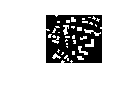

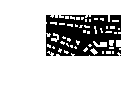

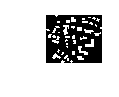

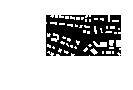

In [8]:
testPath = r"../tmp_data/Data/Testing/"
all_records = []
    
records = predict_15k_examples(testPath, r"FTest1_input_inv.png", r"FTest1_output_inv.png", nr = 1)
all_records.extend(records)
    
records = predict_15k_examples(testPath, r"FTest2_input_inv.png", r"FTest2_output_inv.png", nr = 1)
all_records.extend(records)

records = predict_15k_examples(testPath, r"FTest1_input_inv.png", r"FTest1_output_inv.png", nr = 10)
all_records.extend(records)
    
records = predict_15k_examples(testPath, r"FTest2_input_inv.png", r"FTest2_output_inv.png", nr = 10)
all_records.extend(records)

In [9]:
import pandas as pd
df = pd.DataFrame(np.transpose(all_records))
df.columns = ["Input vs Target (Test1)", "Prediction vs Target (Test1 - 1)", 
              "Input vs Target (Test2)", "Prediction vs Target (Test2 - 1)",
              "Input vs Target (Test1)", "Prediction vs Target (Test1 - 10)", 
              "Input vs Target (Test2)", "Prediction vs Target (Test2 - 10)"]

df = df.rename({0: "Accuracy", 1: 'IoU'})
df.index.name = 'Metrics'

df[["Input vs Target (Test1)", "Prediction vs Target (Test1 - 1)", "Prediction vs Target (Test1 - 10)"]]

,Input vs Target (Test1),Input vs Target (Test1),Prediction vs Target (Test1 - 1),Prediction vs Target (Test1 - 10)
Metrics,,,,
Accuracy,0.976413,0.976413,0.990534,0.989398
IoU,0.885579,0.885579,0.953339,0.947743


In [10]:
df[["Input vs Target (Test2)", "Prediction vs Target (Test2 - 1)", "Prediction vs Target (Test2 - 10)"]]

,Input vs Target (Test2),Input vs Target (Test2),Prediction vs Target (Test2 - 1),Prediction vs Target (Test2 - 10)
Metrics,,,,
Accuracy,0.982896,0.982896,0.993431,0.992333
IoU,0.926102,0.926102,0.971257,0.966565


In [11]:
gan.generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 32) 128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        activation_1[0][0]               
__________________________________________________________________________________________________
add_1 (Add)                     (None, 128, 128, 32) 0           batch_normalization_2[0][0]      
                                                                 conv2d_2[0][0]                   
__________

In [12]:
gan.discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
activation_16 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 256)       295168    
__________